In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [152]:
sample_size = 30
sim_count = 50

simulated_data = pd.DataFrame(columns = range(0,sample_size))
simulated_level = pd.DataFrame(columns = range(0,sample_size))

for sim in range(0,sim_count):
#     alpha = np.random.uniform(0,.95)
    alpha = .15
    simulated_level.loc[sim,0] = np.random.normal(0,1)
    simulated_data.loc[sim,0] = np.random.normal(0,1)
    
    for time in range(1, sample_size):
        ep = np.random.normal(0,1)
        simulated_data.loc[sim,time] = simulated_level.loc[sim,time-1] + ep
        simulated_level.loc[sim,time] = simulated_level.loc[sim,time-1] + (1-alpha)*ep

In [153]:
def exp_smooth(Y,alpha):
    smooth = [Y[0]]
    for t in range(1, len(Y)):
        smooth.append( (1-alpha)*Y[t] + (alpha)* smooth[t-1])    
    return smooth

def objective(Y,alpha,penalty):
    data = pd.DataFrame({'Y':Y, 'est':exp_smooth(Y,alpha)})
    data['est'] = data['est'].shift(1)
    data = data.dropna()
    
    sum_squares = np.square(data['Y'] - data['est']).sum() + penalty*abs(alpha)
    return sum_squares

def minimal_alpha(Y, penalty, grid_size):
    alphas = np.linspace(0,1,grid_size)
    
    min_alpha = 0.0
    min_obj = np.square( np.diff( np.array(Y)) ).sum()
    
    for alpha in alphas:
        sum_squares = 0.0
        forecast = Y[0]
        
        for t in range(1, len(Y)):
            sum_squares = sum_squares + np.square(Y[t]-forecast)
            forecast = (1-alpha)*Y[t] + alpha*forecast
        
        obj = sum_squares + penalty*alpha
        
        if obj < min_obj:
            min_alpha = alpha
            min_obj = obj
            
    return min_alpha

# Alpha SES for all data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002871C44A340>]],
      dtype=object)

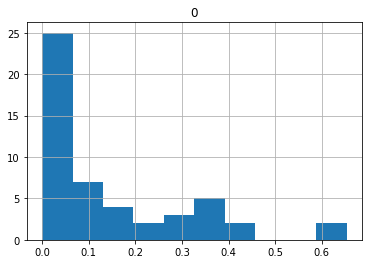

In [154]:
min_alphas = []

for index in simulated_data.index:
    ts = simulated_data.loc[index].values
    min_alphas.append( minimal_alpha(ts,0.0, 50) )
    
pd.DataFrame(min_alphas).hist()

## Analysis for all series

In [155]:
test_df = pd.DataFrame(columns = ['ses','lasso','ses_sse','lasso_sse'])

for series in simulated_data.index:
    Y = simulated_data.loc[series].values
    sample_size = len(Y)
    
    train_index = range(0, round(sample_size/2.0) )
    test_index = range(round(sample_size/2.0), sample_size)
    
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    
    penalty = 2.5
    
    alpha_ses = minimal_alpha(Y, 0.0, 200)
    alpha_lasso = minimal_alpha(Y,penalty, 200)
    
    sse_list = []
    
    for alpha in [alpha_ses, alpha_lasso]:
        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
        sse_list.append(test_sse)
    
    test_df.loc[series,'ses'] = alpha_ses
    test_df.loc[series,'lasso'] = alpha_lasso
    test_df.loc[series,'ses_sse'] = sse_list[0]
    test_df.loc[series,'lasso_sse'] = sse_list[1]
    
print( len(test_df.query('lasso_sse < ses_sse'))/len(test_df))
print( len(test_df.query('lasso_sse <= ses_sse'))/len(test_df))

0.4
0.7


In [156]:
test_df.query('ses_sse == lasso_sse')

,ses,lasso,ses_sse,lasso_sse
3,0,0,15.7053,15.7053
16,0,0,14.4924,14.4924
17,0,0,16.6487,16.6487
18,0,0,3.86285,3.86285
21,0,0,11.466,11.466
24,0,0,11.6545,11.6545
26,0,0,18.9841,18.9841
32,0,0,15.0765,15.0765
35,0,0,18.1049,18.1049
36,0,0,14.0562,14.0562


# Values across various Alpha

In [194]:
outcome_df = pd.DataFrame(columns = ['alpha','penalty', '<','<=','sse_ratio'])    
sample_size = 20
sim_count = 1000
i=0

for alpha_sim in np.linspace(.05, .95, 5):
    simulated_data = pd.DataFrame(columns = range(0,sample_size))
    simulated_level = pd.DataFrame(columns = range(0,sample_size))

    for sim in range(0,sim_count):
        alpha = alpha_sim
        simulated_level.loc[sim,0] = np.random.normal(0,1)
        simulated_data.loc[sim,0] = np.random.normal(0,1)

        for time in range(1, sample_size):
            ep = np.random.normal(0,1)
            simulated_data.loc[sim,time] = simulated_level.loc[sim,time-1] + ep
            simulated_level.loc[sim,time] = simulated_level.loc[sim,time-1] + (1-alpha)*ep

    for penalty in np.linspace(0.0, 4.0, 9):
        test_df = pd.DataFrame(columns = ['ses','lasso','ses_sse','lasso_sse'])

        for series in simulated_data.index:
            Y = simulated_data.loc[series].values
            sample_size = len(Y)

            train_index = range(0, round(sample_size/2.0) )
            test_index = range(round(sample_size/2.0), sample_size)

            Y_train = Y[train_index]
            Y_test = Y[test_index]


            alpha_ses = minimal_alpha(Y, 0.0, 200)
            alpha_lasso = minimal_alpha(Y,penalty, 200)

            sse_list = []

            for alpha in [alpha_ses, alpha_lasso]:
                exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,alpha)})
                exp_df['exp'] = exp_df['exp'].shift(1) 
                exp_df = exp_df.reset_index()
                test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
                sse_list.append(test_sse)

            test_df.loc[series,'ses'] = alpha_ses
            test_df.loc[series,'lasso'] = alpha_lasso
            test_df.loc[series,'ses_sse'] = sse_list[0]
            test_df.loc[series,'lasso_sse'] = sse_list[1]

        outcome_df.loc[i,'<'] =  len(test_df.query('lasso_sse < ses_sse'))/len(test_df)
        outcome_df.loc[i,'<='] =  len(test_df.query('lasso_sse <= ses_sse'))/len(test_df)
        outcome_df.loc[i,'sse_ratio'] = np.mean((test_df['lasso_sse'] - test_df['ses_sse'])/test_df['ses_sse'])
        outcome_df.loc[i,'penalty'] = penalty
        outcome_df.loc[i,'alpha'] = alpha_sim
        i = i+1

Text(0.5, 1.0, 'Percent weakly improved by Lasso plotted against lambda for various alpha')

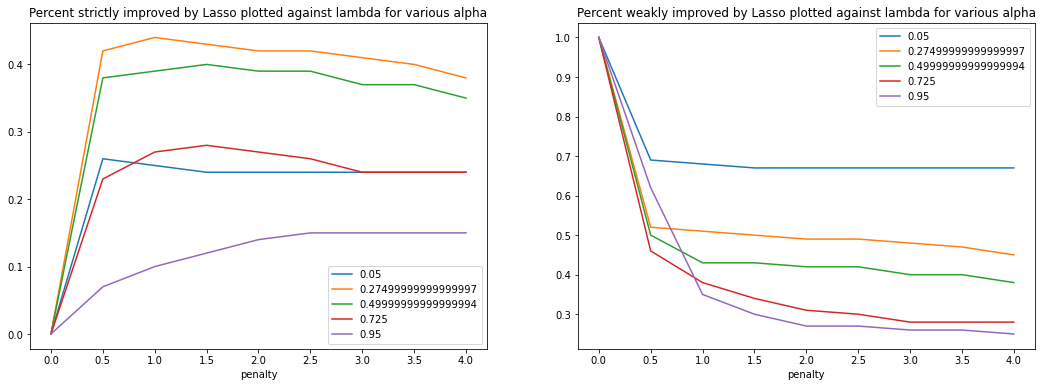

In [200]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (18,6))

for a_val in outcome_df['alpha'].unique():
    outcome_df.query('alpha == @a_val').set_index('penalty')['<'].plot(ax = ax1)
    outcome_df.query('alpha == @a_val').set_index('penalty')['<='].plot(ax = ax2)

ax1.legend(outcome_df['alpha'].unique())
ax2.legend(outcome_df['alpha'].unique())

ax1.set_title('Percent strictly improved by Lasso plotted against lambda for various alpha')
ax2.set_title('Percent weakly improved by Lasso plotted against lambda for various alpha')

# Misspecified model, AR(1)

In [190]:
ar_outcome_df = pd.DataFrame(columns = ['alpha','penalty', '<','<=','sse_ratio'])    
sample_size = 20
sim_count = 100
omega = 1.0
i=0

for alpha_sim in np.linspace(.05, .95, 5):
    simulated_data = pd.DataFrame(columns = range(0,sample_size))

    for sim in range(0,sim_count):
        alpha = alpha_sim
        simulated_data.loc[sim,0] =  np.random.normal(0,1) 

        for time in range(1, sample_size):
            ep = np.random.normal(0,1)
            simulated_data.loc[sim,time] = omega + alpha *simulated_data.loc[sim,time-1] + ep

    for penalty in np.linspace(0.0, 4.0, 9):
        test_df = pd.DataFrame(columns = ['ses','lasso','ses_sse','lasso_sse'])

        for series in simulated_data.index:
            Y = simulated_data.loc[series].values
            sample_size = len(Y)

            train_index = range(0, round(sample_size/2.0) )
            test_index = range(round(sample_size/2.0), sample_size)

            Y_train = Y[train_index]
            Y_test = Y[test_index]


            alpha_ses = minimal_alpha(Y, 0.0, 200)
            alpha_lasso = minimal_alpha(Y,penalty, 200)

            sse_list = []

            for alpha in [alpha_ses, alpha_lasso]:
                exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,alpha)})
                exp_df['exp'] = exp_df['exp'].shift(1) 
                exp_df = exp_df.reset_index()
                test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
                sse_list.append(test_sse)

            test_df.loc[series,'ses'] = alpha_ses
            test_df.loc[series,'lasso'] = alpha_lasso
            test_df.loc[series,'ses_sse'] = sse_list[0]
            test_df.loc[series,'lasso_sse'] = sse_list[1]

        ar_outcome_df.loc[i,'<'] =  len(test_df.query('lasso_sse < ses_sse'))/len(test_df)
        ar_outcome_df.loc[i,'<='] =  len(test_df.query('lasso_sse <= ses_sse'))/len(test_df)
        ar_outcome_df.loc[i,'sse_ratio'] = np.mean((test_df['lasso_sse'] - test_df['ses_sse'])/test_df['ses_sse'])
        ar_outcome_df.loc[i,'penalty'] = penalty
        ar_outcome_df.loc[i,'alpha'] = alpha_sim
        i = i+1

NameError: name 'ar_outcome_df' is not defined

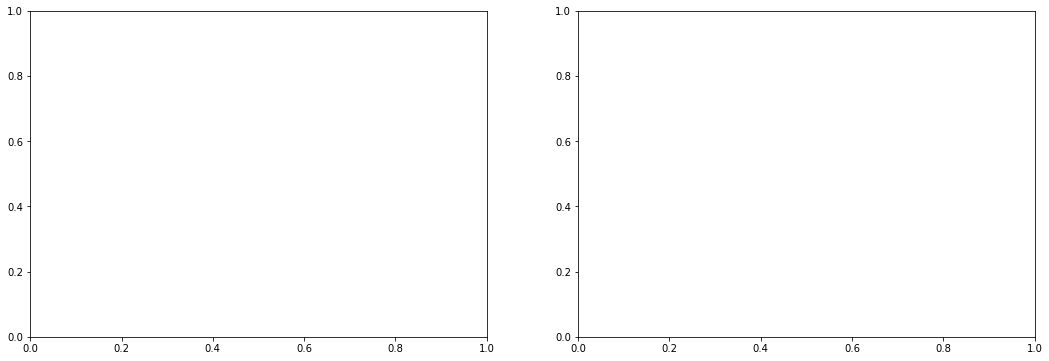

In [201]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (18,6))

for a_val in ar_outcome_df['alpha'].unique():
    ar_outcome_df.query('alpha == @a_val').set_index('penalty')['<'].plot(ax = ax1)
    ar_outcome_df.query('alpha == @a_val').set_index('penalty')['<='].plot(ax = ax2)

ax1.legend(ar_outcome_df['alpha'].unique())
ax2.legend(ar_outcome_df['alpha'].unique())

ax1.set_title('Percent strictly improved by Lasso plotted against lambda for various alpha')
ax2.set_title('Percent weakly improved by Lasso plotted against lambda for various alpha')